# PMT Single Photon Test

### TODO

##### Python

- `int` -> `np.uint16` may be faster?


##### List

- Show average signal
- get peak value distribution
- get threshold 

##### Other

- circuit simulation

### Require Package & Tools

Please execute this cell at first.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm
from scipy.special import factorial
from scipy.optimize import leastsq, curve_fit, basinhopping
import math
from functools import partial
from collections import Counter

# tools for analysis
def get_bits(data: bytes, bit: int = 0):
    return int.from_bytes(bytes=data, byteorder='little') & ((1 << bit + 1) - 1)

def to_int(data: bytes):
    return int.from_bytes(bytes=data, byteorder='little')

def get_chn(data: int):
    data_len = len(bin(data))-2
    return [i for i in range(data_len) if data & (1 << i)]

### Plot Single Signal / Total Signal

- 20% single photon signal

In [26]:
def plt_signal_set(title: str):
    plt.title(title)
    plt.xlabel('sample')
    plt.ylabel('Voltage / mV')
    plt.grid()

def moving_average(a, n, mode = 'same'):
    return(np.convolve(a, np.ones((n,))/n, mode=mode))

def plt_signal(file: str, count: int = 0, title: str = '', chn_list = range(16), raw = True):
    plt_legend = []
    chn_count = Counter()
    with open(file , mode='rb') as f:
        ev_count = 0
        while (True):
            ev_header = f.read(4 << 2)
            ## VALIDATE EVENT 
            ev_check = ev_header[3] >> 4 
            if (ev_check != 10):
                break
            ## GET EVENT SIZE
            ev_size = get_bits(ev_header[:4], 27)
            ## GET BOARD EVENT COUNT
            ev_count = to_int(ev_header[8:11])
            # if ev_count != count:
            #     f.seek((ev_size - 4) << 2,1)
            #     continue
            ## GET CHANNEL MASK
            ev_chn_mask = get_chn(ev_header[4])
            ## INIT CHANNEL CHECK
            chn_check = 0
            while(len(ev_chn_mask)):
                chn_header = f.read(3 << 2)
                ## GET CHANNEL SIZE
                chn_size = get_bits(chn_header[:3], 22) 
                chn_id = ev_chn_mask.pop(0)
                chn_count[chn_id] += 1
                if not (chn_id in chn_list and count + 1 == chn_count[chn_id])  :
                    f.seek((chn_size - 3) << 2, 1)
                    continue
                # chn_check = chn_check | (1 << chn_id)
                chn_base = to_int(chn_header[-2:])
                ## GET SIGNAL LIST
                raw_data = f.read((chn_size - 3) << 2)
                sig_list = ( (0 if raw else chn_base) - np.frombuffer(raw_data, dtype=np.int16).astype(int))
                plt.plot(range(len(sig_list)), sig_list)
                #############################
                ## high pass filter
                # sn = np.fft.fft(sig_list[0:200])
                # sn[75:125] = 0
                # sig_list = np.fft.fft(sn).real[::-1] / 200 
                # plt.plot(range(40,140), sig_list[39:139])
                ##############################
                plt.show()
                # sp = np.fft.fft(sig_list**2)
                # freq = np.fft.fftfreq(np.arange(len(sig_list)).shape[-1])
                # plt_legend.append(chn_id)
                # plt.plot(freq, sp.real)
                # plt.show()
                break
            # plt.legend(plt_legend)
            # plt_signal_set(title)

def plt_tot_signal(file: str, count: int = 0, title: str = ''):
    chn_total_signal = {}
    with open(file , mode='rb') as f:
        ev_count = 0
        while (True):
            ev_header = f.read(4 << 2)
            if (len(ev_header) == 0) :
                break
            ## VALIDATE EVENT 
            ev_check = ev_header[3] >> 4 
            if (ev_check != 10):
                break
            ## GET EVENT SIZE
            ev_size = get_bits(ev_header[:4], 27)
            ## GET BOARD EVENT COUNT
            ev_count = to_int(ev_header[8:11])
            ev_chn_mask = get_chn(ev_header[4])
            ## INIT CHANNEL CHECK
            chn_check = 0
            while(len(ev_chn_mask)):
                chn_header = f.read(3 << 2)
                ## GET CHANNEL SIZE
                chn_size = get_bits(chn_header[:3], 22) 
                chn_id = ev_chn_mask.pop(0)
                chn_check = chn_check | (1 << chn_id)
                chn_base = to_int(chn_header[-2:])
                ## GET SIGNAL LIST
                raw_data = f.read((chn_size - 3) << 2)
                sig_list = (chn_base - np.frombuffer(raw_data, dtype=np.int16).astype(int)) / (1 << 13) * 1000 
                # sig_list = np.fft.fft(sig_list[0:150]).real ** 2
                try:
                    chn_total_signal[chn_id] += sig_list
                except:
                    chn_total_signal[chn_id] = sig_list

        for k,i in chn_total_signal.items():
            plt.figure(figsize = (10,8))
            plt.plot(i)
            # plt.plot(np.linspace(-100,100,150),i)
            plt.title(f'chn{k}')
            # plt.savefig(f'chn{k}tot.png',dpi=300)
            # plt.close()
            plt.grid()
            plt.show()

## Main

# for i in range(110,150):
#     plt_signal(f"../../data/850/2_63_850V_raw_b0_seg0.bin", i, f'Signal (2.63V)')
#     # plt.show()

# plt_signal(f"../../data/850/2_56_850V_raw_b0_seg0.bin", 25, f'Signal (2.61V)')

# plt_tot_signal(f"../../data/850/2_60_850V_raw_b0_seg0.bin",title= f'Signal (2.61V)')

### Analyse Data

- 2V total with $2^{14}$ voltage resolution
- 0.25GHz time resolution (4ns/signal)
<!-- - baseline range: $[20,80)$ and $[105, 200)$ , average all data
- event range: $[85, 100)$ -->

##### Basic Tools

Before proceeding, you should execute this cell to activate the tools.

In [6]:
class Config:
    ## Default settings
    _max_voltage = 2000
    _y_resolution = 16384
    _default_scale = _max_voltage * 4 *10 / (_y_resolution * 50 * 1.6) # area (1*1) ~ electron count (1e6)
    ## signal range
    _signal_start = 5
    _signal_end = 200
    ## Peak range = (peak_index - before, peak_index + after)
    _default_peak_index = 89
    _event_before = 4  # 10 
    _event_after  = 5  # 10 
    ## Baseline config
    _use_all_base = False       # If `False`, only use base1
    _calc_all_base = False      # If `False`, only calculate base1
    _interval = 3               # interval between baseline bounds and event bounds
    _base_cut_front = 75
    _base_cut_back = 110
    ## Find peak settings
    ### True: find peak as `peak_index` in search range. False: use `_default_peak_index`. Search range = (_search_start , _search_end)
    _fix_event_range = True
    _search_start = 85
    _search_end = 100
    ## Veto settings
    ### if `True`, event with peak outside veto range will be excluded. Veto range = (_veto_start , _veto_end)
    _veto_event = False
    _veto_start = 90
    _veto_end = 95
    ### Advanced Setting
    _fix_base_length = True   # If `False`, baseline range will change with peak index
    _find_avg_peak = False
    _calc_base_std = False # TODO: set it!


class CHN_Data(Config):
    def __init__ (self, chn: int):
        super(CHN_Data, self).__init__()
        self.chn=chn  
        self.base_info = []      # list[tuple] : (base1_avg, base1_stdev, base2_avg, base2_stdev, base_avg, base_stdev)
        self.event_area = []     # event area of all events
        self.peak_value = []
        self.peak_index = []     # Temp!!!
        self.dist = {}
        self.peak_dist = {}
        self.event_count = 0

    def update(self, raw_data: bytes):
        # event_list = np.fromiter([raw_data[i] + (raw_data[i + 1] << 8) for i in range( 0 , len(raw_data) , 2)], dtype=np.int16) # FIXME: Need optimize ~27s
        event_list = np.frombuffer(raw_data, dtype=np.uint16).astype(int) # FIXME: Need optimize ~27s
        ### find peak and get event range
        if self._fix_event_range:
            peak_index = self._default_peak_index
        else:
            if self._find_avg_peak:
                peak_range = np.argpartition(event_list[self._search_start:self._search_end], 2)[:2]
                if (abs((peak_range[0]-peak_range[1]) )  != 1):
                    return
                peak_index = peak_range[0] + self._search_start
            else:
                peak_index = np.argmin(event_list[self._search_start:self._search_end]) + self._search_start
            if self._veto_event and not (self._veto_start <= peak_index <= self._veto_end):
                return
        event_start , event_end = peak_index - self._event_before, peak_index + self._event_after 
        event = event_list[event_start : event_end]
        ## get raw area
        self.event_area.append(np.sum(event))
        ## Analyse baseline
        ### baseline before event
        base1 = event_list[ self._signal_start : self._base_cut_front if self._fix_base_length else (event_start - self._interval) ]
        base1_avg = np.sum(base1) / len(base1)
        base1_stdev = np.sqrt(np.sum(base1**2) / len(base1) - base1_avg ** 2)  if self._calc_base_std else -1
        if self._calc_all_base:
            ### baseline after event
            base2 = event_list[ self._base_cut_back if self._fix_base_length else (event_end + self._interval) : self._signal_end ]
            base2_avg = np.sum(base2) / len(base2)
            base2_stdev = np.sqrt(np.sum(base2**2) / len(base2) - base2_avg ** 2) if self._calc_base_std else -1
            ### total baseline
            base = np.concatenate((base1, base2))
            base_avg = np.sum(base) / len(base)
            base_stdev = np.sqrt(np.sum(base**2) / len(base) - base_avg ** 2) if self._calc_base_std else -1
        else:
            base2_avg, base2_stdev, base_avg, base_stdev = -1, -1, -1, -1           # Maybe `empty` can be better??
        self.base_info.append((base1_avg, base1_stdev, base2_avg, base2_stdev, base_avg, base_stdev))
        ## Analyse (Raw) Peak Value 
        self.peak_value.append(np.min(event_list))          # FIXME: event_list???
        self.peak_index.append(np.argmin(event_list))     # FIXME: Temp, get indics
        ## Count ++
        self.event_count += 1

    def get_distribution(self):
        if len(self.event_area) == 0:
            return
        self.dist = Counter()
        self.event_area = np.array(self.event_area)
        # self.event_area = np.array(self.event_area)
        base = np.array(self.base_info).T[4 if self._use_all_base else 0]
        area= np.round(base * (self._event_before+ self._event_after)- self.event_area)
        for i in area:
            self.dist[i] += 1

    def get_peak_distribution(self, base = 0):
        if len(self.peak_value) == 0:
            return
        self.peak_dist = Counter()
        peak = zip(self.peak_index, self.peak_value)
        for i in peak:
            self.peak_dist[round(base - i[1])] += 1
        

    def get_from_file(self,   data_list, mode: str):
        header = np.fromstring(data_list[0], int , sep=',')
        if (len(header) <= 1):
            return
        chn, chn.event_count = header
        if chn != self.chn:
            return
        ## set mode
        if mode == 'raw':
            self.event_area  = np.fromstring(data_list[1], float , sep=',').astype(int)
            self.base_info = np.array([np.fromstring(s, sep=',', dtype=float) for s in data_list[2:]]).T
            self.get_distribution()
        if mode == 'dist':
            x    = np.fromstring(data_list[1], int , sep=',')
            dist = np.fromstring(data_list[2], int , sep=',')
            self.dist = dict(zip(x, dist))
        if mode == 'peak':
            self.peak_value = np.fromstring(data_list[1], float , sep=',')
            self.get_peak_distribution()

In [9]:
def plot(x, y, subplt, title: str, scale: float = 1, fontsize= 5 , xlim= None, ylim=None,  aspect= .8, s=3, marker = 'o'):
    if len(x) == 0:
        return
    x = np.array(x) * scale
    subplt.scatter(x , y , s=s, marker = marker)
    # subplt.plot(x , y , lw = 1)    # FIXME: TEMP
    if xlim:
        subplt.set_xlim(*xlim)
    if ylim:
        subplt.set_ylim(*ylim)
    subplt.set_box_aspect(aspect)
    subplt.set_title(f"{title}",  pad=3)

def plot_ecount(chn: CHN_Data, subplt,  title: str, **kwargs):
    x , y = list(chn.dist.keys()), list(chn.dist.values())
    plot(x,y,subplt, title,   **kwargs)
    subplt.set_xlabel('electron count / x10^6 e-',  labelpad=3)
    subplt.set_ylabel('Event count')

def plot_pcount(chn: CHN_Data, subplt,  title: str, **kwargs):
    x , y = np.array(sorted(list(chn.peak_dist.items()), key= lambda x : x[0])).T  # FIXME: TEMP
    # x , y = list(chn.peak_dist.keys()), list(chn.peak_dist.values()) # FIXME: TEMP
    plot(x,y,subplt, title,**kwargs)
    # plot(x,y,subplt, title, scale = chn._max_voltage / chn._y_resolution, **kwargs)
    subplt.set_xlabel('peak value ',  labelpad=3)
    subplt.set_ylabel('Event count')

def plot_idist(chn: CHN_Data, subplt,  title: str, **kwargs):
    x , y = -np.array(chn.peak_value) , chn.peak_index
    plot(x,y,subplt, title, **kwargs)

# def plot_icount(chn: CHN_Data, subplt,  title: str, **kwargs):
#     idist = np.array(sorted(list(chn.peak_idist.items()), key = lambda x : x[0])[75:100]).T
#     x , y = idist
#     plot(x,y,subplt, title)

def save_raw_to_file(chn: CHN_Data, file: str):
    if len(chn.event_area) == 0:
        return
    with open(file, "a") as f:
        np.savetxt(f, [[chn.chn, chn.event_count], chn.event_area], delimiter=',', fmt='%d')
        base_info_T = np.array(chn.base_info).T
        np.savetxt(f,base_info_T, fmt='%.4f', delimiter=',')

def save_dist_to_file(chn:CHN_Data, file:str):
    if len(chn.dist) == 0:
        if len(chn.event_area) == 0:
            return
        chn.get_distribution()
    with open(file, 'a') as f:
        # header , e count , number
        np.savetxt(f, [[chn.chn, chn.event_count], list(chn.dist.keys()), list(chn.dist.values())] , delimiter=',', fmt='%d')

def save_peak_to_file(chn: CHN_Data, file: str):
    if len(chn.peak_value) == 0:
        return
    with open(file, "a") as f:
        # header , peak_value
        np.savetxt(f, [[chn.chn, chn.event_count]], delimiter=',', fmt='%d')
        np.savetxt(f, [chn.peak_value], delimiter=',', fmt='%f')


def read_file(file: str, mode: str = 'raw'): # mode in {'raw', 'dist'}
    chn_data = {}
    with open(file, 'r') as f:
        while(True):
            header = np.fromstring(f.readline(), int , sep=',')
            if (len(header) <= 1):
                break
            chn = CHN_Data(header[0])
            chn.event_count = header[1]
            if mode == 'raw':
                chn.event_area  = np.fromstring(f.readline(), float , sep=',').astype(int)
                chn.base_info = np.array([np.fromstring(f.readline(), sep=',', dtype=float) for s in range(6)]).T
                # base1_avg   = np.fromstring(f.readline(), float , sep=',')
                # base1_stdev = np.fromstring(f.readline(), float , sep=',')
                # base2_avg   = np.fromstring(f.readline(), float , sep=',')
                # base2_stdev = np.fromstring(f.readline(), float , sep=',')
                # base_avg    = np.fromstring(f.readline(), float , sep=',')
                # base_stdev  = np.fromstring(f.readline(), float , sep=',')
                # chn.base_info = list(zip(base1_avg , base1_stdev , base2_avg  , base2_stdev , base_avg , base_stdev))
                chn.get_distribution()
            elif mode == 'dist':
                x    = np.fromstring(f.readline(), int , sep=',')
                dist = np.fromstring(f.readline(), int , sep=',')
                chn.dist = dict(zip(x, dist))
            elif mode == 'peak':
                chn.peak_value = np.fromstring(f.readline(), float , sep=',')
                chn.get_peak_distribution()
            else:
                raise Exception
            chn_data[chn.chn] = chn
    return chn_data

def analyse_raw_data(file:str, loop= -1):
    chn_data = {}
    with open(file, mode='rb')as f:
        while (True):
            ## GET HEADER
            ev_header = f.read(4 << 2)
            if len(ev_header) == 0:
                break
            ## VALIDATE EVENT
            ev_check = ev_header[3] >> 4
            if ev_check != 0b1010:
                break
            ## GET EVENT SIZE
            ev_size = get_bits(ev_header[:4], 27)
            ## GET BOARD EVENT COUNT
            ev_count = to_int(ev_header[8:11])
            ## GET CHANNEL MASK
            ev_chn_mask = get_chn(ev_header[4])
            while(len(ev_chn_mask)):
                chn_header = f.read(3 << 2)
                ## GET CHANNEL SIZE
                chn_size = get_bits(chn_header[:3], 22) 
                ## GET CHANNEL ID
                chn_id = ev_chn_mask.pop(0)
                ## GET SIGNAL LIST
                chn_raw_signal = f.read((chn_size - 3) << 2)
                try:
                    chn_data[chn_id].update(chn_raw_signal)
                except:
                    chn_data[chn_id] = CHN_Data(chn_id)
                    chn_data[chn_id].update(chn_raw_signal)
            if loop != -1 and ev_count > loop:
                break
    return chn_data


In [7]:
data = analyse_raw_data(f'../../data/0710/252_850_0710V_raw_b0_seg0.bin')

In [6]:
def get_peak_distribution(self, base = 0):
    self.peak_dist = Counter()
    peak = zip(self.peak_index, self.peak_value)
    for i in peak:
        self.peak_dist[round(base - i[1])] += 1

In [ ]:
_ = np.where(np.array(data[3].peak_value) == 15155)[0]
print(_[:20])
print(len(_))
for i in _[10:30]:
    plt_signal(f"../../data/850/2_64_850V_raw_b0_seg0.bin", count = i, title = f'Signal (2.63V)', chn_list= (3,))

In [ ]:
fig, ax = plt.subplots(4, 1, figsize=(6,15), dpi=150)
for k, d in data.items():
    # d.get_distribution()
    plot_ecount(d, ax[k-1], f'2.64V ', xlim = (-3,5), scale = d._default_scale)
plt.tight_layout()
plt.show()

##### Decode raw file & write 


In [5]:
# !!!! Execute This First !!!!!
id_min, id_max = 55, 66
id_range = range(id_min, id_max + 1)
ch_list = [1,2,3,4]
xlim_set = dict(zip(ch_list,[15, 10, 10 , 20]))


**File Format**:
- raw:
    - TOTAL BASE AREA: sum of area under base for all event. TOTAL BASE AREA = BASE * TOTAL EVENT SIZE.
    - SIGNAL AREA: area under signal (in selected range).
    ``` ini
        CHANNEL ID 1, TOTAL EVENT_COUNT
        SIG AREA 1, SIG AREA 2, ...
        BASE-A 1, BASE-A2, ...
        BASE-A-STD 1, BASE-A-STD 2, ...
        BASE-B1, BASE-B2, ...
        BASE-B-STD1, BASE-B-STD2, ...
        BASE-TOT1, BASE-TOT2, ...
        BASE-TOT-STD1, BASE-TOT-STD2, ...
        CHANNEL ID 2, TOTAL EVENT COUNT
        ...
    ```

- dist:
    - RANGE START & RANGE END: start and end of the range. This range will be x-range when plotting. Corresponding to COUNT data. 
    ``` ini
        CHANNEL ID 1, TOTAL EVENT COUNT
        AREA 1, AREA 2,...
        COUNT 1 , COUNT 2 , ...
        CHANNEL ID 2, TOTAL EVENT COUNT
        AREA 1, AREA 2,...
        COUNT 1 , COUNT 2 , ...
    ```

**Decode file**:

In [5]:
## Take Too much time. Don't execute this.
for i in tqdm.tqdm(id_range):
    data = analyse_raw_data(f'../../data/850/2_{i}_850V_raw_b0_seg0.bin')
    title = f"2_{i}_850"
    # open(f'raw_{title}.txt', 'w').close()
    # open(f'dist_{title}.txt', 'w').close()
    open(f'850-range-85-94-base-5-75/peak_{title}.txt', 'w').close()
    for d in data.values():
        # save_raw_to_file(d,f'raw_{title}.txt')
        # save_dist_to_file(d,f'dist_{title}.txt')
        save_peak_to_file(d,f'850-range-85-94-base-5-75/peak_{title}.txt')

100%|██████████| 12/12 [17:57<00:00, 89.77s/it]


##### Get data from file

In [5]:
# Read raw data to memory
all_data = {}
for v in tqdm.tqdm(id_range):
    data = read_file(f'850-range-85-94-base-5-75/raw_2_{v}_850.txt', mode='raw')
    all_data[v] = data


100%|██████████| 12/12 [00:53<00:00,  4.50s/it]


In [5]:
# Read dist to memory
all_data = {}
for v in tqdm.tqdm(id_range):
    data = read_file(f'850-range-85-94-base-5-75/dist_2_{v}_850.txt', mode='dist')
    all_data[v] = data

  0%|          | 0/12 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'dist_2_55_850.txt'

##### Plot distribution of electron count

In [ ]:
for chn in ch_list:
    fig, ax = plt.subplots(3,4, dpi=300 , figsize = (15, 9))
    fig.suptitle(f'Channel {chn} (HV = 850V)',y = .99)
    for v in id_range:
        data = all_data[v][chn]
        v_id = v - id_min
        plot(data, ax[v_id // 4][v_id % 4], f'V(LED) = 2.{v}V ', scale=data._default_scale , xlim=(-3, xlim_set[chn]) , s=2)
    plt.tight_layout()
    plt.savefig(f'ch{chn}.png', dpi = 300)
    plt.show()

##### Fit Curve [DEV]

- Poisson Distribution:
$$
P(\boldsymbol{n},l) = \frac{l^n}{n!}\mathrm{e}^{-l}
$$

- Gaussian Distribution: 
$$
G(\boldsymbol{x}, d, s) = \frac{1}{\sqrt{2 \pi}s} \exp\left[-\frac{(x-d)^2}{2 s^2}\right]
$$

- Total Distribution
$$
F(\boldsymbol{x}, A, d_e, s_0, s_e, l_e) = A \sum_{k = 0}^{n} P(k , l_e) G(x, k\, d_e, \sqrt{s_0^2 + k\, s_e ^2})
$$

- Total Distribution with base offset:
$$
F(\boldsymbol{x}, x_0) = A \sum_{k = 0}^{n} P(k , l_e) G(x - x_0, k\, d_e, \sqrt{s_0^2 + k\, s_e ^2})
$$

Basically $n\to \infty$ , but when $l_e$ is small, we can let $n$ be equal to a finite value (e.g. $n = 20$)  

- $A$ : Proportional const.
- $d_e$ : offset of $x$ for a single photon signal. $d_e=1$ means $1\times 10^6\ e^-$ are received in a single photon signal.
- $s_0$ : standard deviation of background noise.
- $s_e$ : standard deviation of a single photon signal.
- $l_e$ : average of signal count in one event(under Poisson distribution).
- $x_0$ : base offset.

**Distribution functions** 

In [10]:
np.set_printoptions(linewidth=300,precision=3, suppress=True)
items = 30

def poisson_dist(n, l):
    return l ** n * np.exp(-l) / factorial(n)

def gaussion_dist(x, d, s):
    return np.exp(-(x-d) ** 2 / (2 * s ** 2)) / (math.sqrt(2 * math.pi) * s)

def dist_func(x, A, de, s0, se, le):
    func = lambda k: A * poisson_dist(k, le) * gaussion_dist(x, k * de, np.sqrt(s0 ** 2 + k * se ** 2)) 
    return sum(func(i) for i in range(items))

def dist_func_r(x, A, de, s0, se, le, k):
    return A * poisson_dist(k, le) * gaussion_dist(x, k * de, np.sqrt(s0 ** 2 + k * se ** 2)) 

## Method : Use `curve_fit`
def process_data(x,y):
    func = dist_func
    init_args = [22000, 3, 0.9, 1.1, 1]
    bounds = (0,(50000, 10,3,8,20))
    popt, pcov = curve_fit(func, x, y,p0=init_args,bounds=bounds, maxfev = 100000 ) # ......
    return x, func(x, *popt), popt, pcov

**Get fit parameters & save**

In [ ]:
xlim_set = dict(zip(ch_list,[15, 10, 10 , 20]))
for chn in ch_list:
    # fig, ax = plt.subplots(3,4, dpi=300 , figsize = (15, 9))
    # fig.suptitle(f'Channel {chn} fit result (HV = 850V)',y = .99)
    print('U        A          de        s0        se       lambda  σ-A    σ-de    σ-s0    σ-se   σ-lambda  ')
    with open(f'fit_ch{chn}.txt', mode='w') as f:
        f.write(f'{chn}'+'\n')
        for v in id_range:
            ## Fit
            data = all_data[v][chn]
            dist = data.dist
            x = np.array(sorted(dist.keys()))
            y = np.array([dist[i] for i in x])
            x = x * data._default_scale
            x_pre, y_pre, popt, pcov = process_data(x,y)
            print(f'2.{v}', popt, np.sqrt(np.diag(pcov)))

            ## Write file
            f.write(f'2.{v},')
            np.savetxt(f,[np.concatenate(( popt, np.sqrt(np.diag(pcov)) ))],  delimiter=',', newline='') 
            f.write('\n')

        #     # Plot
        #     v_id = v - id_min
        #     ax0 = ax[v_id // 4][v_id % 4]
        #     ax0.plot(x,y_pre, c='0', linewidth = 1)
        #     for k in range(7):
        #         ax0.plot(x,[dist_func_r(i, *popt, k) for i in x], linewidth = 1)
        #     plot(data, ax0, f'V(LED) = 2.{v}V ', scale=data._default_scale , xlim=(-3, xlim_set[chn]) , s=2)

        # plt.tight_layout()
        # plt.savefig(f'ch{chn}-fit.png', dpi = 300)
        # plt.show()

**Read fit result from file**

In [17]:
def get_fit(file:str):
    with open(file, mode='r') as f:
        data = f.readlines()
        chn = int(data.pop(0))
        fit_result = [] 
        for i in data:
            fit = np.fromstring(i, dtype = float, sep = ',')
            fit_result.append(fit)
        fit_result = np.array(fit_result)
    return chn, fit_result

fit_data = {}       # {chn 1 : [(volt 1, *popt 1, *pcov_d 1), ...] , ...}
for chn in ch_list:
    fit_data[chn] = get_fit(f'fit_ch{chn}.txt')[1]

**Plot fit result**

U        A          de        s0        se       lambda  σ-A    σ-de    σ-s0    σ-se   σ-lambda  
2.55 [21832.185     2.275     0.711     1.605     0.205] [63.707  0.104  0.003  0.082  0.01 ]
2.56 [22744.219     2.271     0.714     1.592     0.261] [78.805  0.102  0.004  0.08   0.013]
2.57 [23832.11      2.316     0.708     1.599     0.341] [74.53   0.072  0.004  0.058  0.012]
2.58 [20235.225     2.337     0.704     1.598     0.44 ] [60.631  0.056  0.004  0.046  0.012]
2.59 [22009.184     2.426     0.704     1.585     0.562] [64.2    0.044  0.004  0.038  0.011]
2.60 [22357.306     2.508     0.709     1.562     0.713] [51.94   0.029  0.003  0.026  0.009]
2.61 [19296.685     2.528     0.709     1.552     0.895] [42.564  0.025  0.004  0.022  0.01 ]
2.62 [25826.116     2.555     0.701     1.528     1.237] [53.503  0.022  0.004  0.019  0.011]
2.63 [23348.084     2.617     0.707     1.504     1.583] [38.469  0.017  0.004  0.015  0.011]
2.64 [22128.104     2.611     0.688     1.486     2.077]

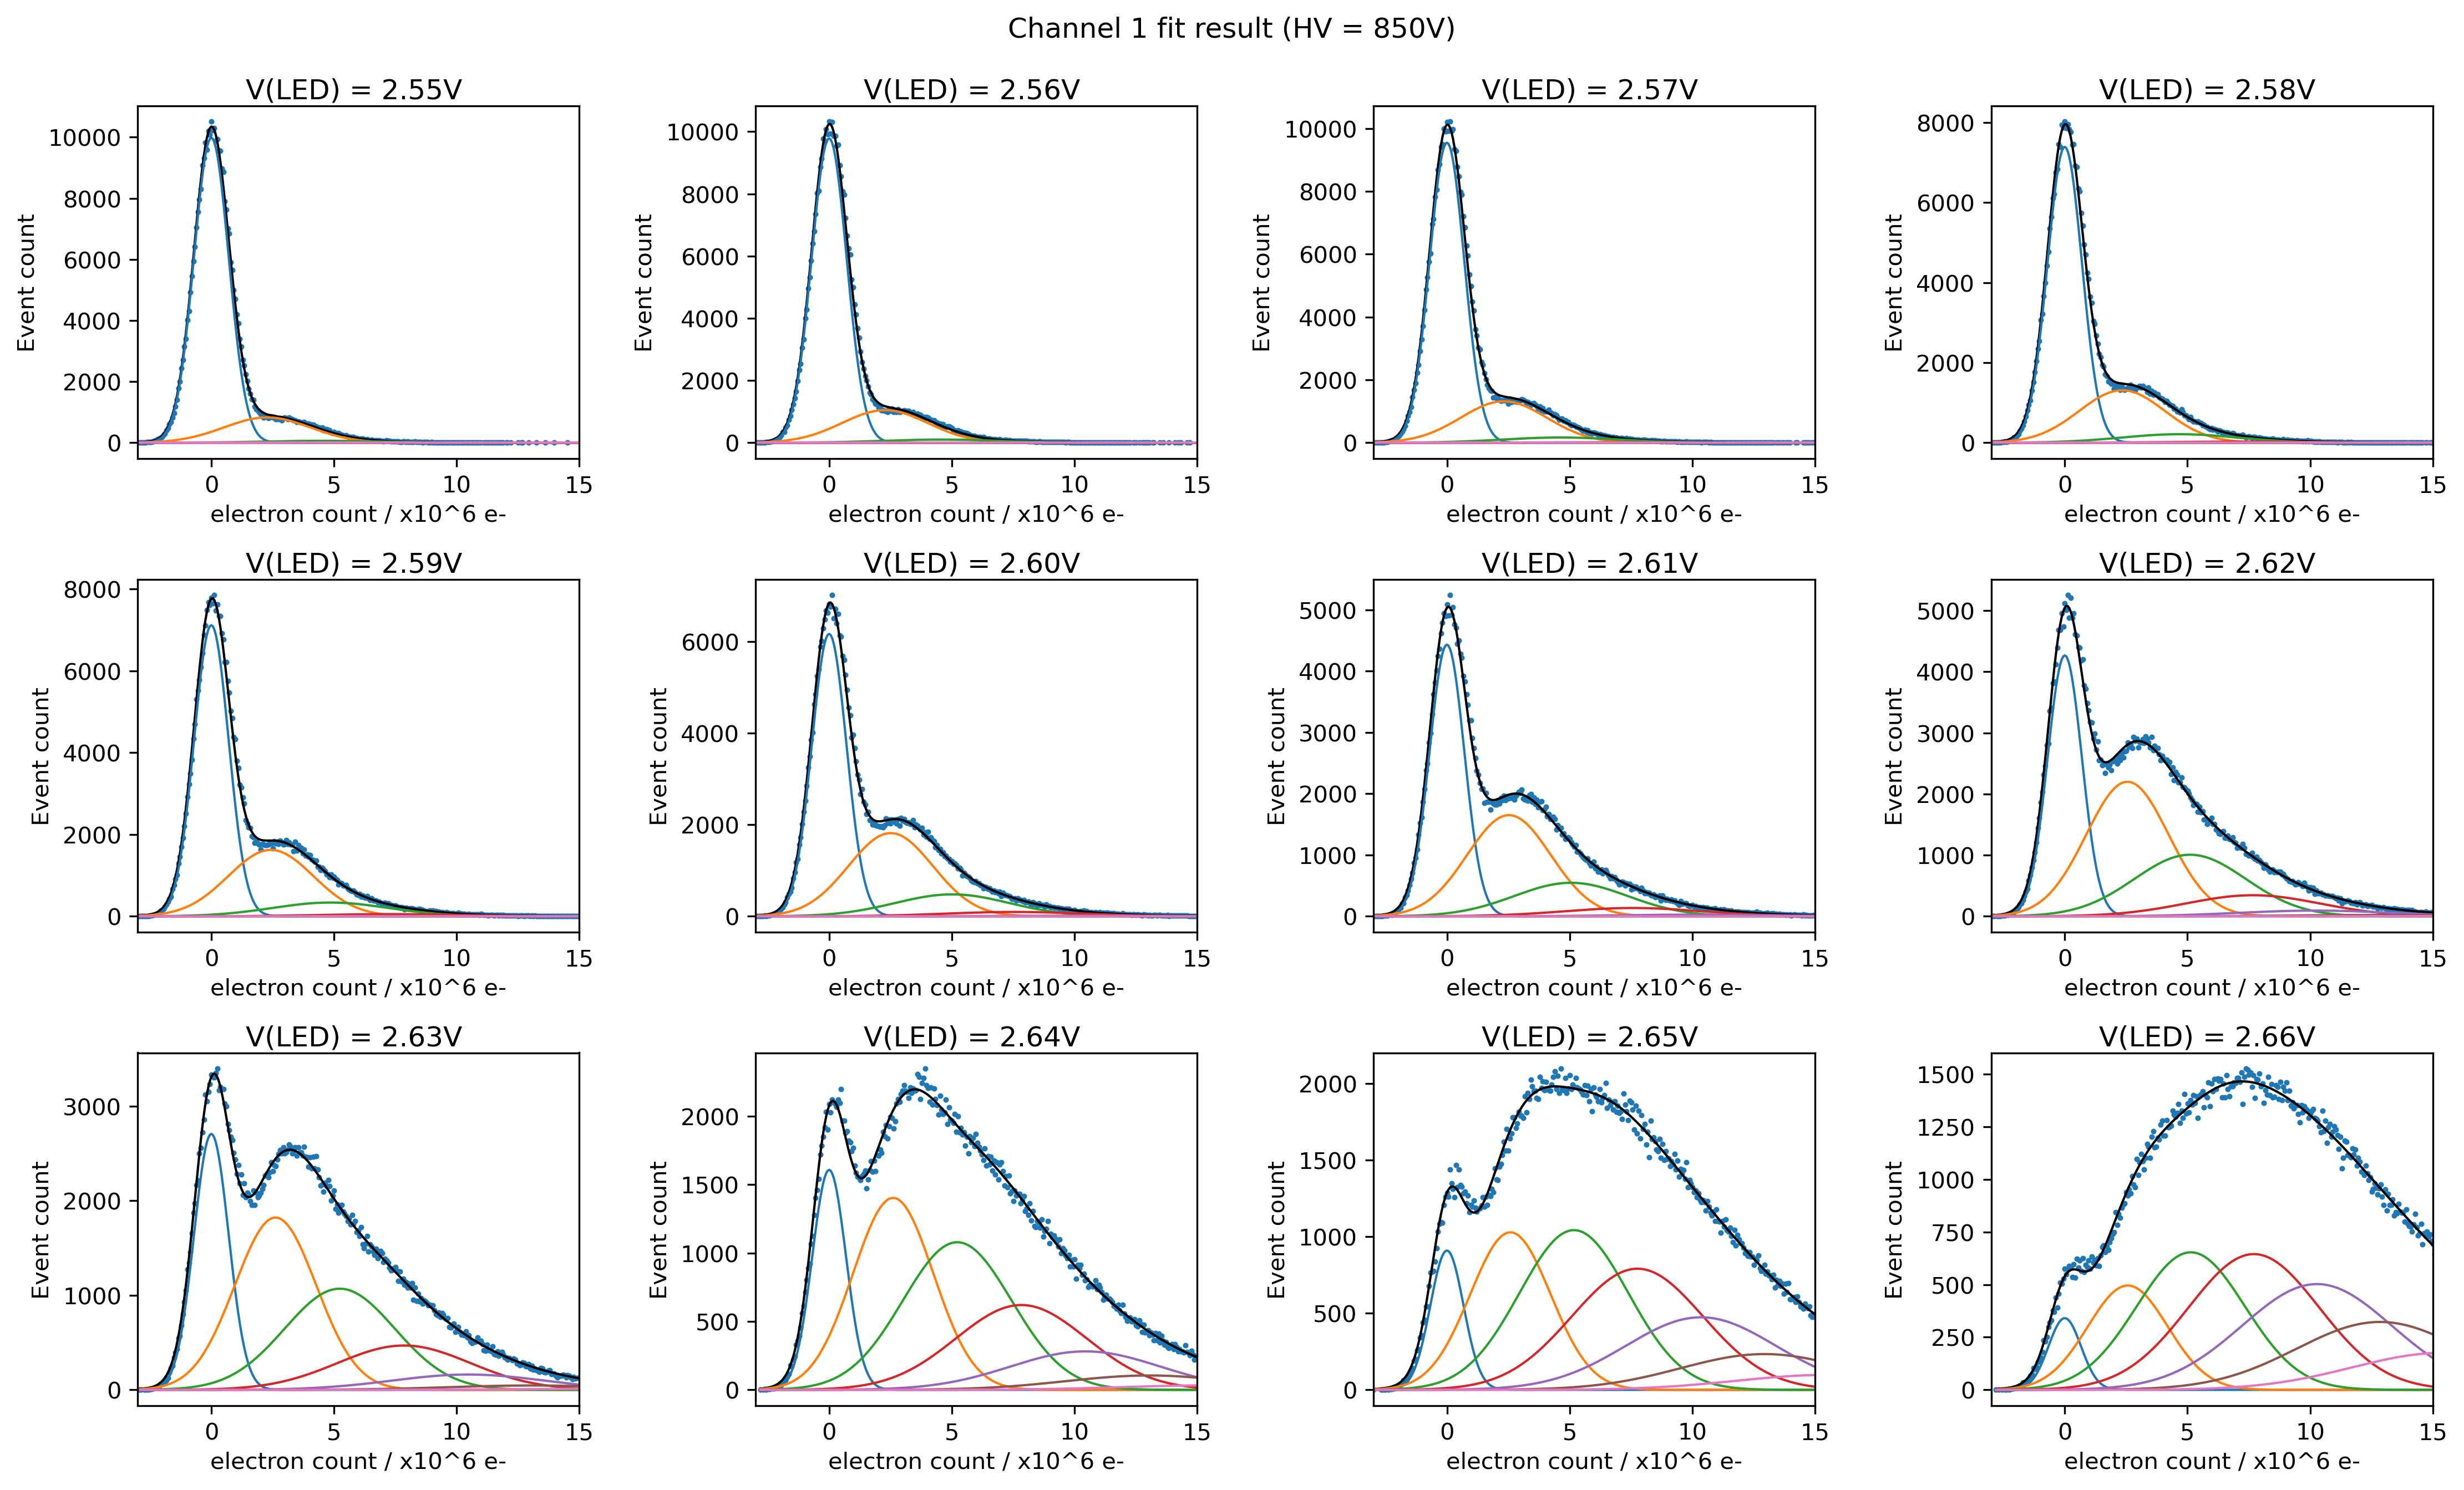

U        A          de        s0        se       lambda  σ-A    σ-de    σ-s0    σ-se   σ-lambda  
2.55 [21834.213     1.842     0.935     1.236     0.129] [52.337  0.23   0.004  0.164  0.018]
2.56 [22681.871     1.566     0.95      1.16      0.201] [69.454  0.301  0.008  0.174  0.039]
2.57 [23766.2       1.655     0.945     1.212     0.255] [63.939  0.2    0.007  0.119  0.032]
2.58 [20048.381     1.33      0.809     1.074     0.405] [85.789  0.205  0.013  0.101  0.061]
2.59 [21969.251     1.724     0.96      1.233     0.416] [60.809  0.138  0.008  0.084  0.034]
2.60 [22343.611     1.804     0.951     1.254     0.529] [56.512  0.097  0.007  0.062  0.03 ]
2.61 [19292.256     1.895     0.973     1.268     0.624] [41.823  0.07   0.006  0.047  0.024]
2.62 [25795.611     1.903     0.929     1.242     0.87 ] [48.673  0.046  0.006  0.032  0.023]
2.63 [23331.504     1.964     0.918     1.22      1.101] [40.233  0.035  0.005  0.025  0.021]
2.64 [22115.01      1.885     0.894     1.255     1.479]

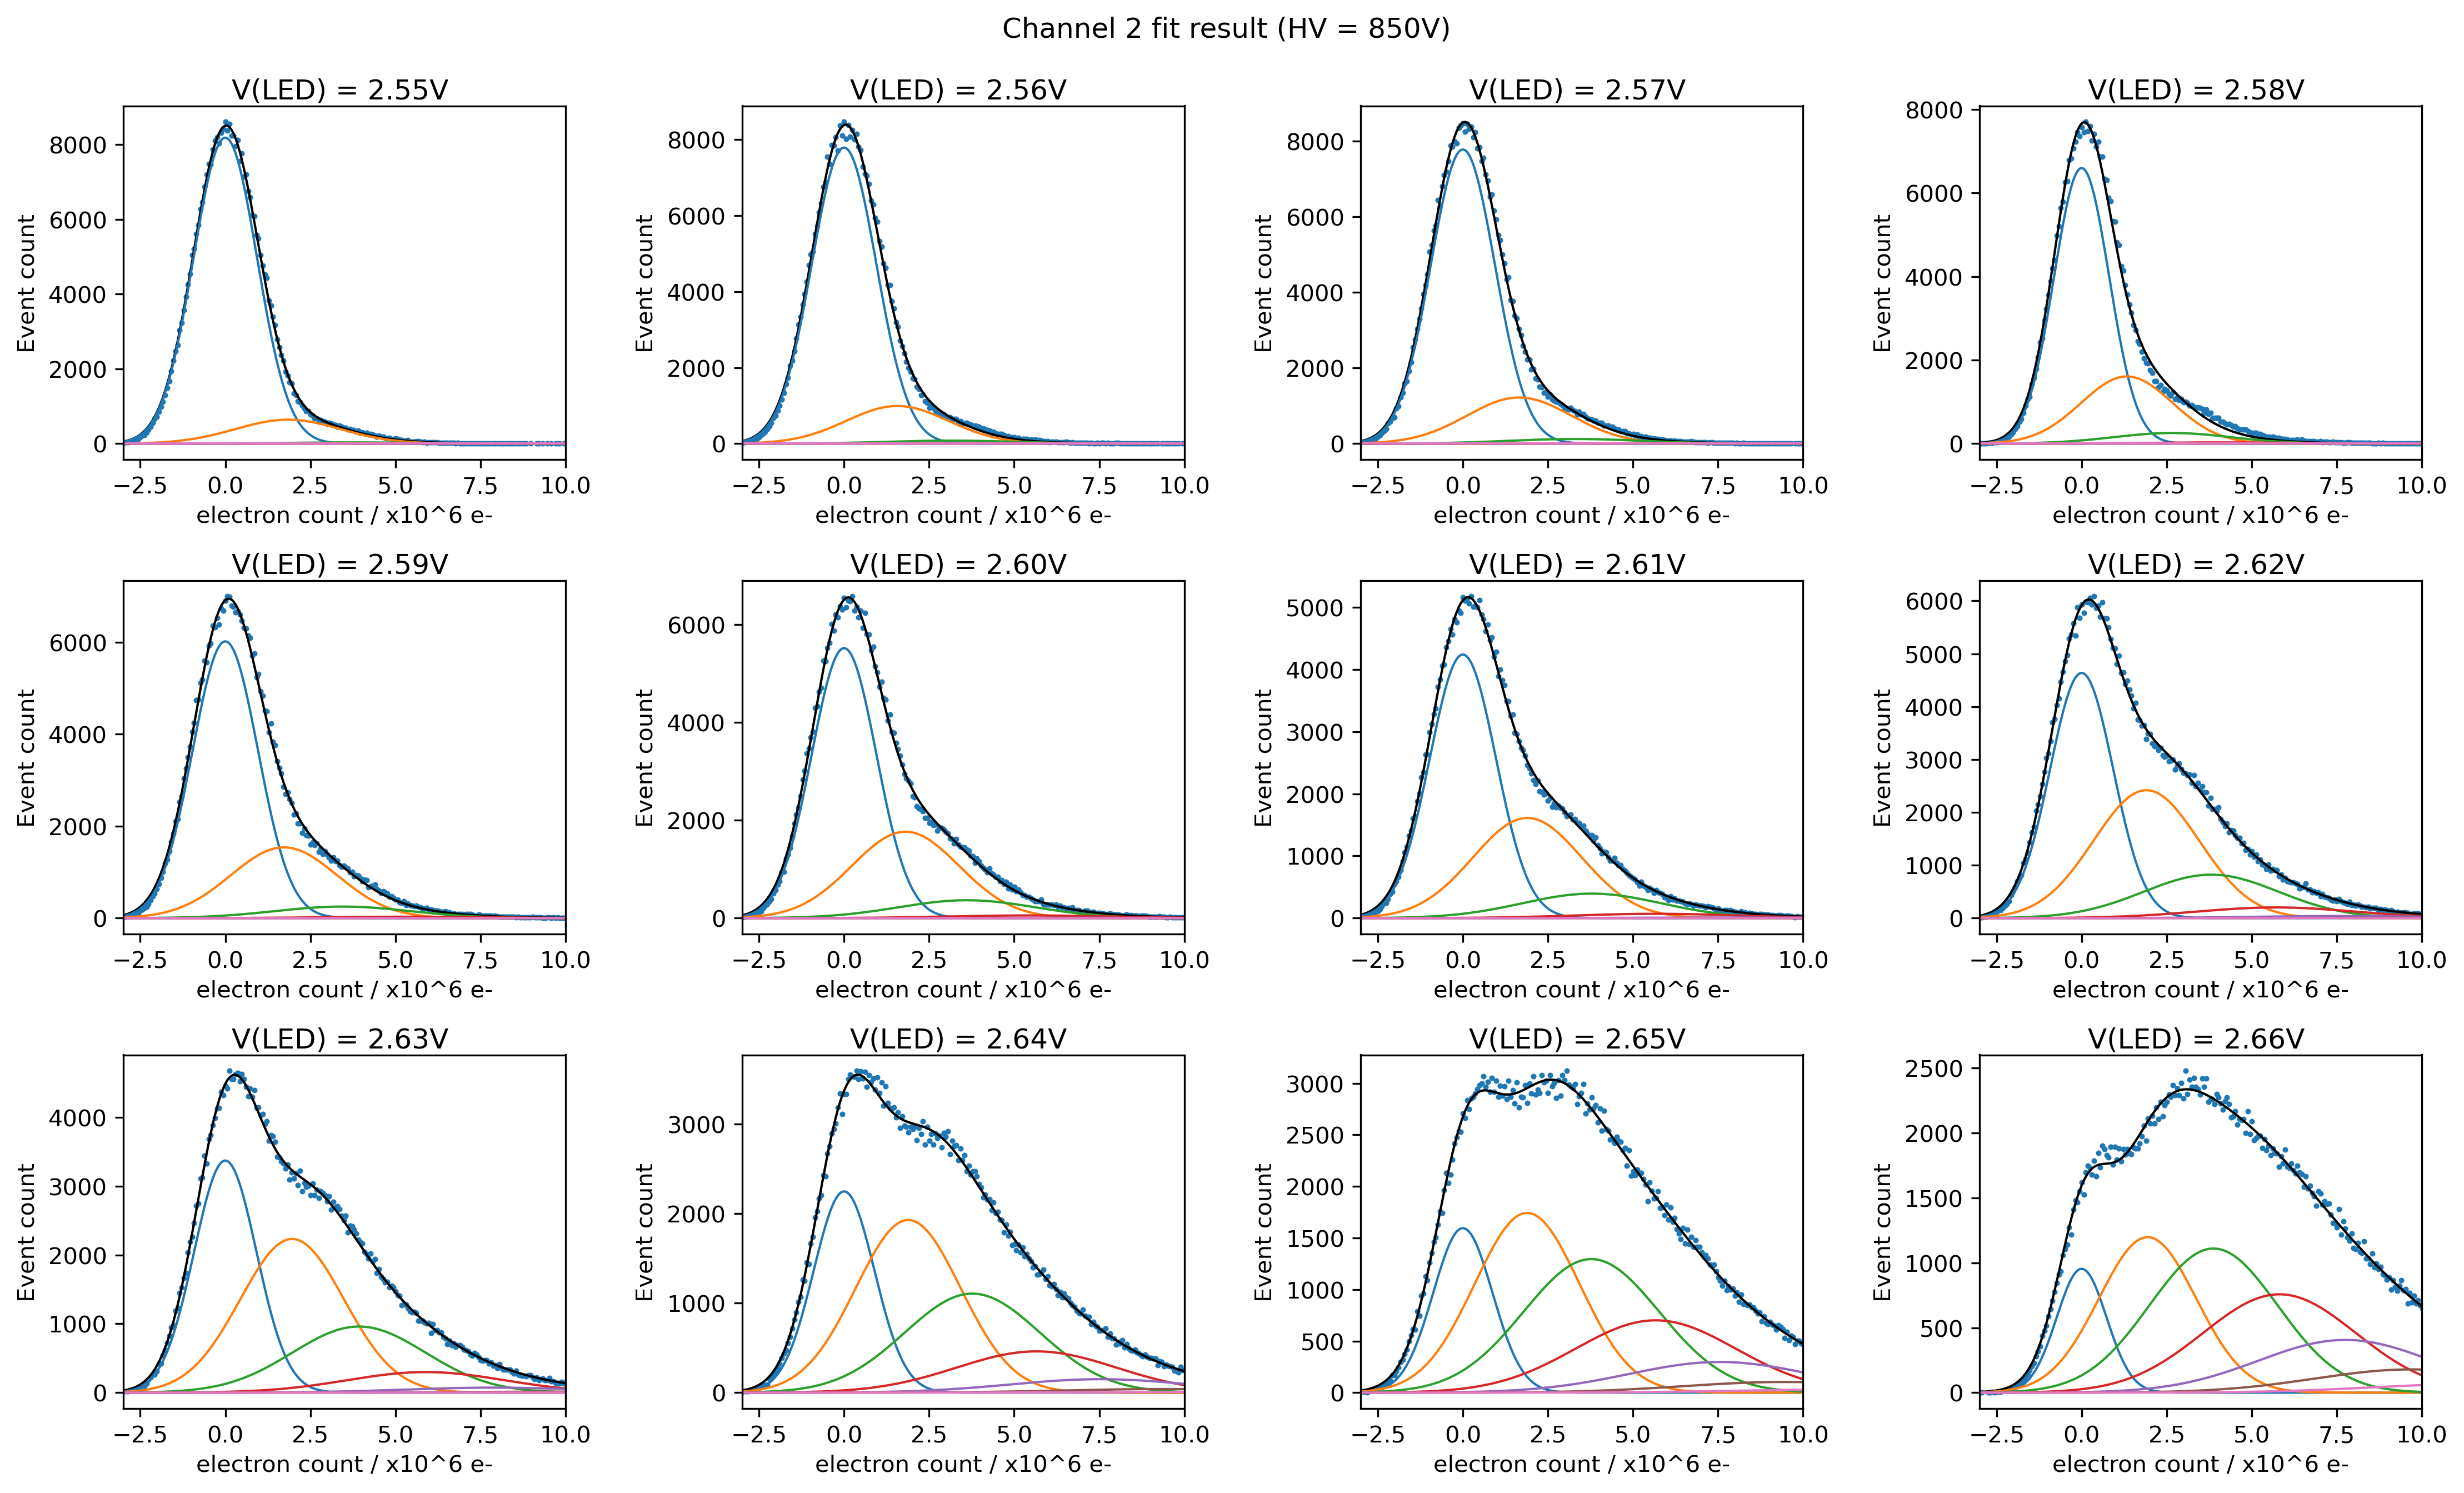

U        A          de        s0        se       lambda  σ-A    σ-de    σ-s0    σ-se   σ-lambda  
2.55 [21782.965     1.9       0.876     1.423     0.133] [47.691  0.21   0.004  0.131  0.015]
2.56 [22679.801     1.92      0.888     1.425     0.171] [56.539  0.195  0.005  0.122  0.018]
2.57 [23768.773     1.92      0.869     1.429     0.227] [63.273  0.156  0.006  0.098  0.019]
2.58 [19981.868     1.443     0.675     1.185     0.342] [167.646   0.257   0.015   0.137   0.058]
2.59 [21979.003     2.002     0.857     1.451     0.368] [63.191  0.108  0.006  0.071  0.02 ]
2.60 [22352.651     2.11      0.851     1.469     0.464] [52.422  0.068  0.005  0.048  0.016]
2.61 [19293.474     2.287     0.861     1.411     0.534] [42.687  0.044  0.004  0.036  0.012]
2.62 [25804.181     2.481     0.891     1.305     0.677] [49.479  0.022  0.003  0.021  0.007]
2.63 [23318.24      2.446     0.873     1.32      0.891] [42.222  0.02   0.004  0.019  0.009]
2.64 [22109.764     2.536     0.892     1.227     1

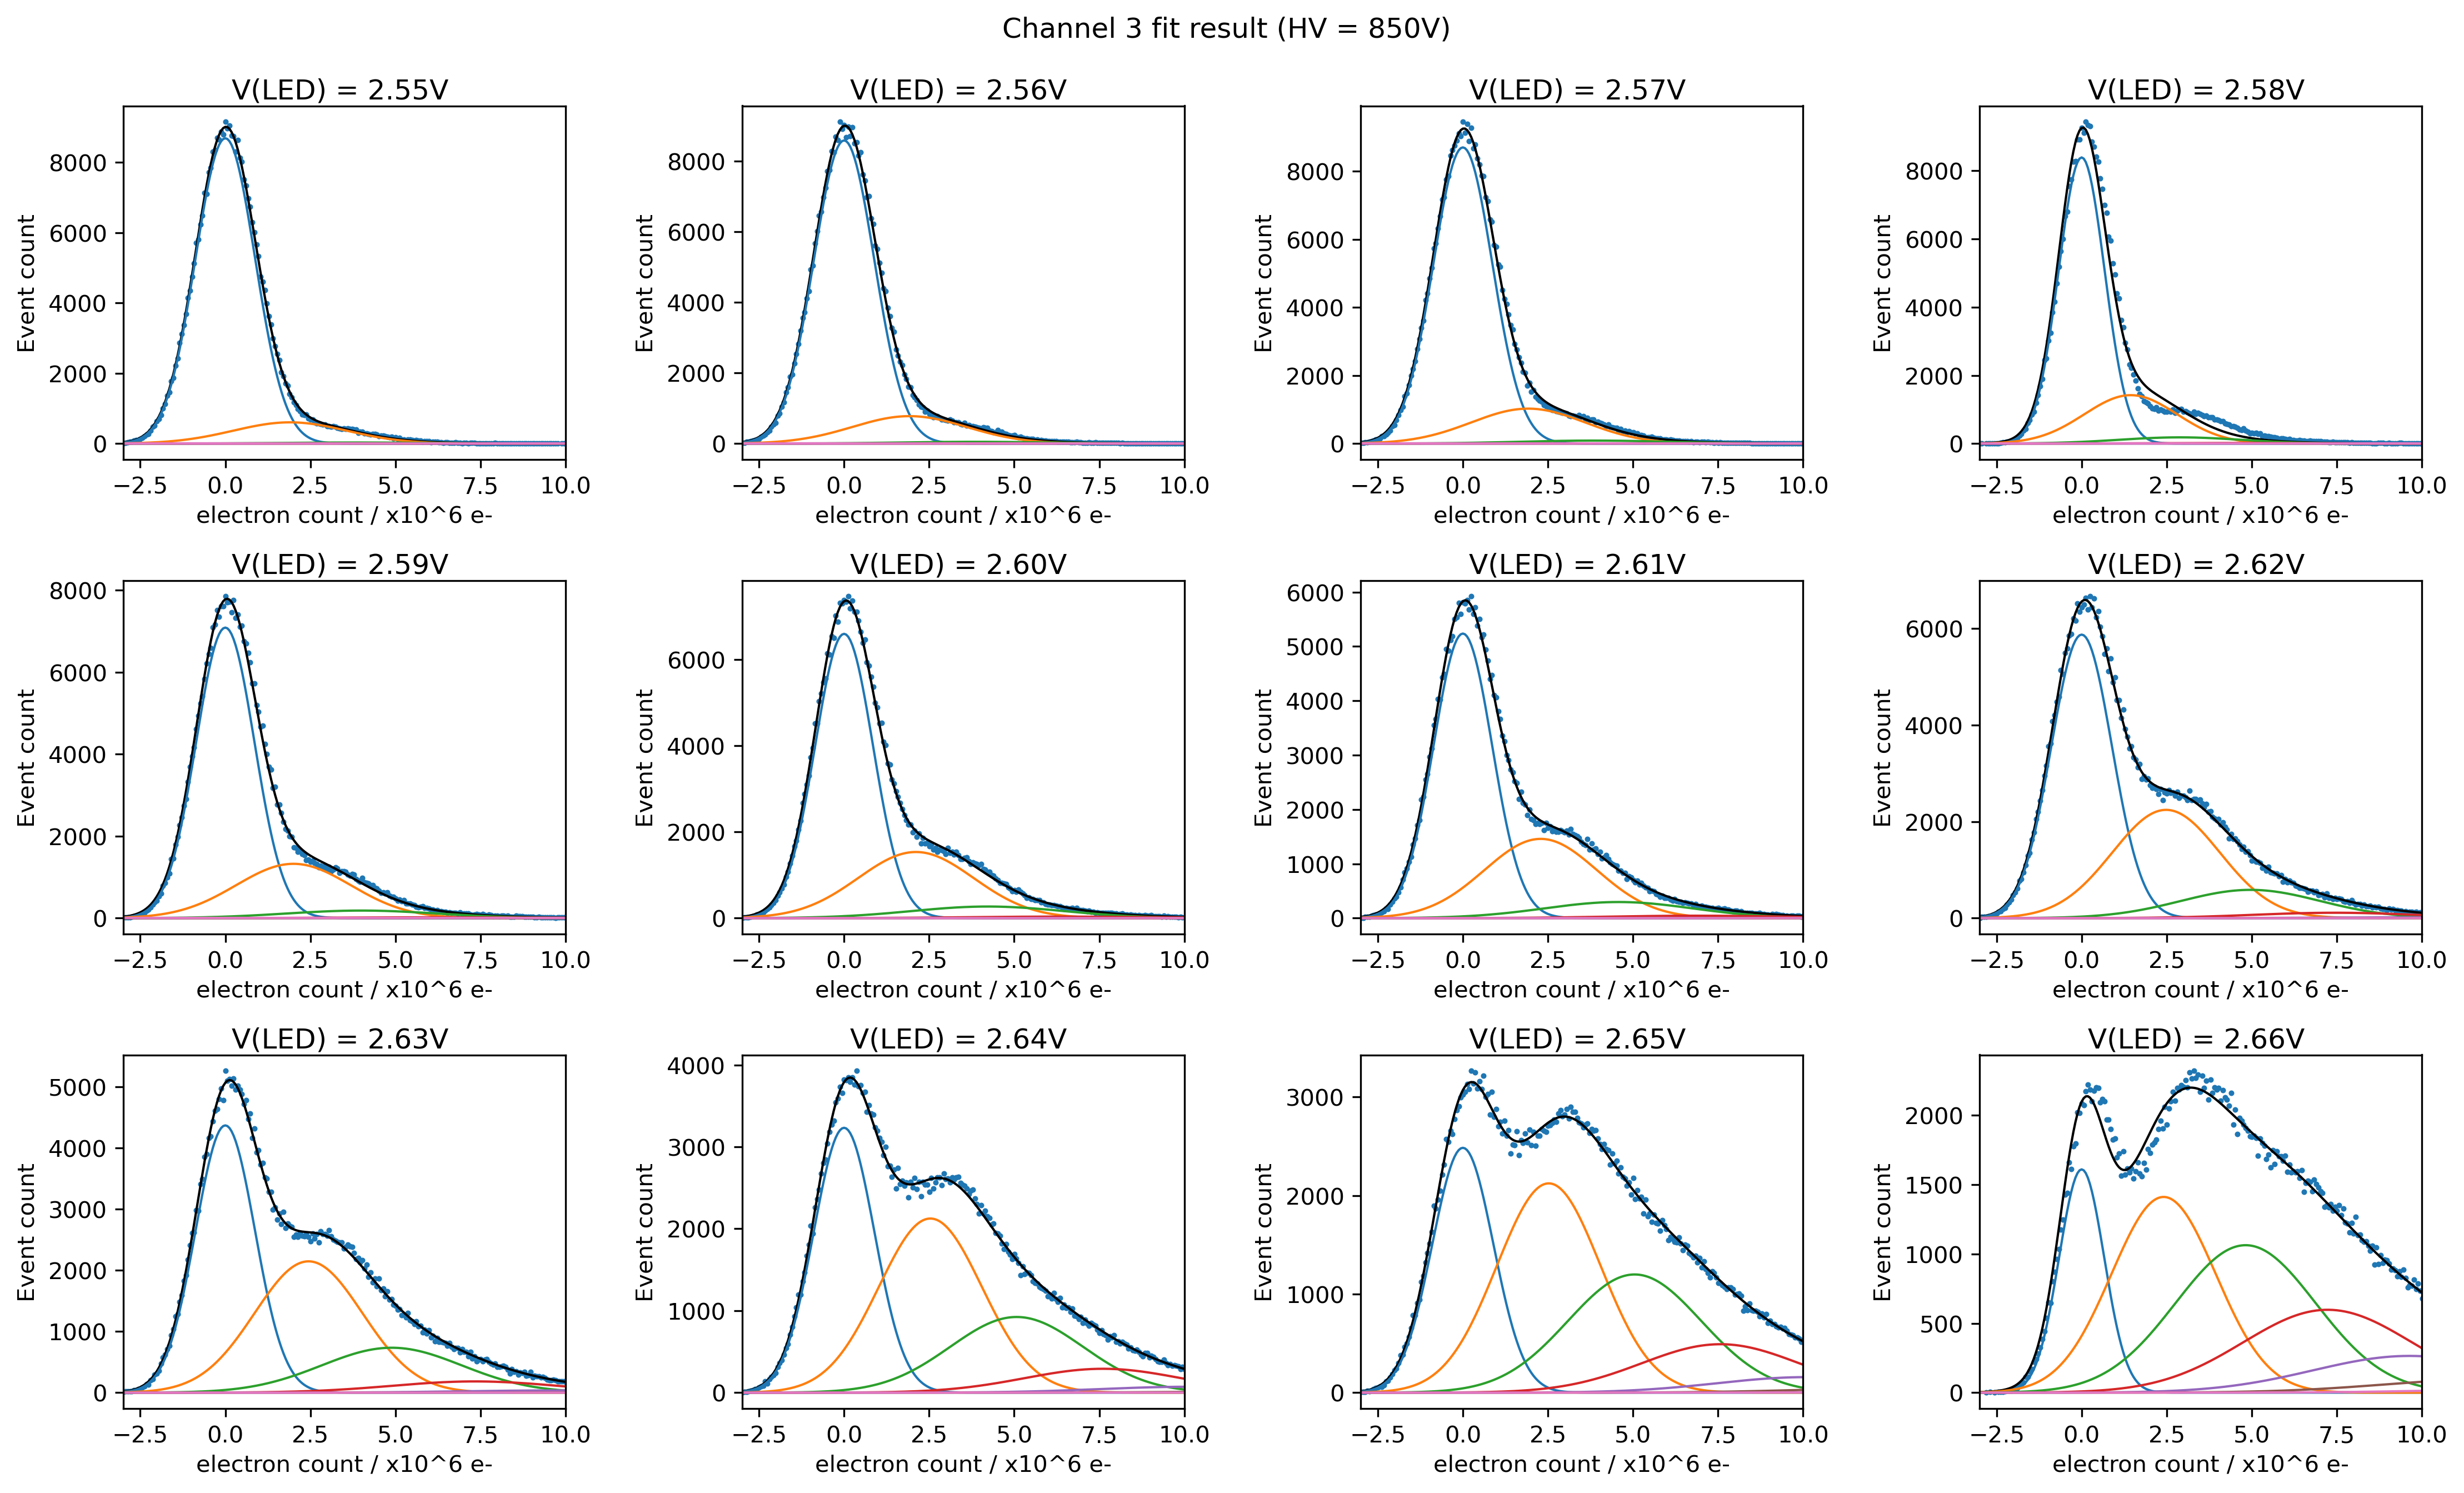

U        A          de        s0        se       lambda  σ-A    σ-de    σ-s0    σ-se   σ-lambda  
2.55 [21909.029     3.021     1.099     2.123     0.544] [70.657  0.101  0.009  0.072  0.019]
2.56 [22794.403     3.138     1.115     2.105     0.68 ] [62.31   0.073  0.008  0.055  0.017]
2.57 [23889.71      3.181     1.109     2.122     0.88 ] [65.6    0.066  0.009  0.049  0.019]
2.58 [20269.857     3.276     1.112     2.088     1.112] [46.559  0.049  0.009  0.037  0.018]
2.59 [22020.975     3.37      1.112     2.031     1.432] [43.622  0.038  0.009  0.03   0.017]
2.60 [22346.043     3.401     1.091     2.02      1.881] [41.277  0.039  0.012  0.03   0.023]
2.61 [19261.255     3.424     1.083     2.013     2.348] [31.229  0.041  0.015  0.031  0.029]
2.62 [25727.726     3.438     1.085     1.966     3.261] [38.224  0.062  0.031  0.045  0.06 ]
2.63 [23257.392     3.438     1.033     1.967     4.273] [34.892  0.115  0.071  0.079  0.145]
2.64 [22051.787     3.338     0.935     2.008     5.768]

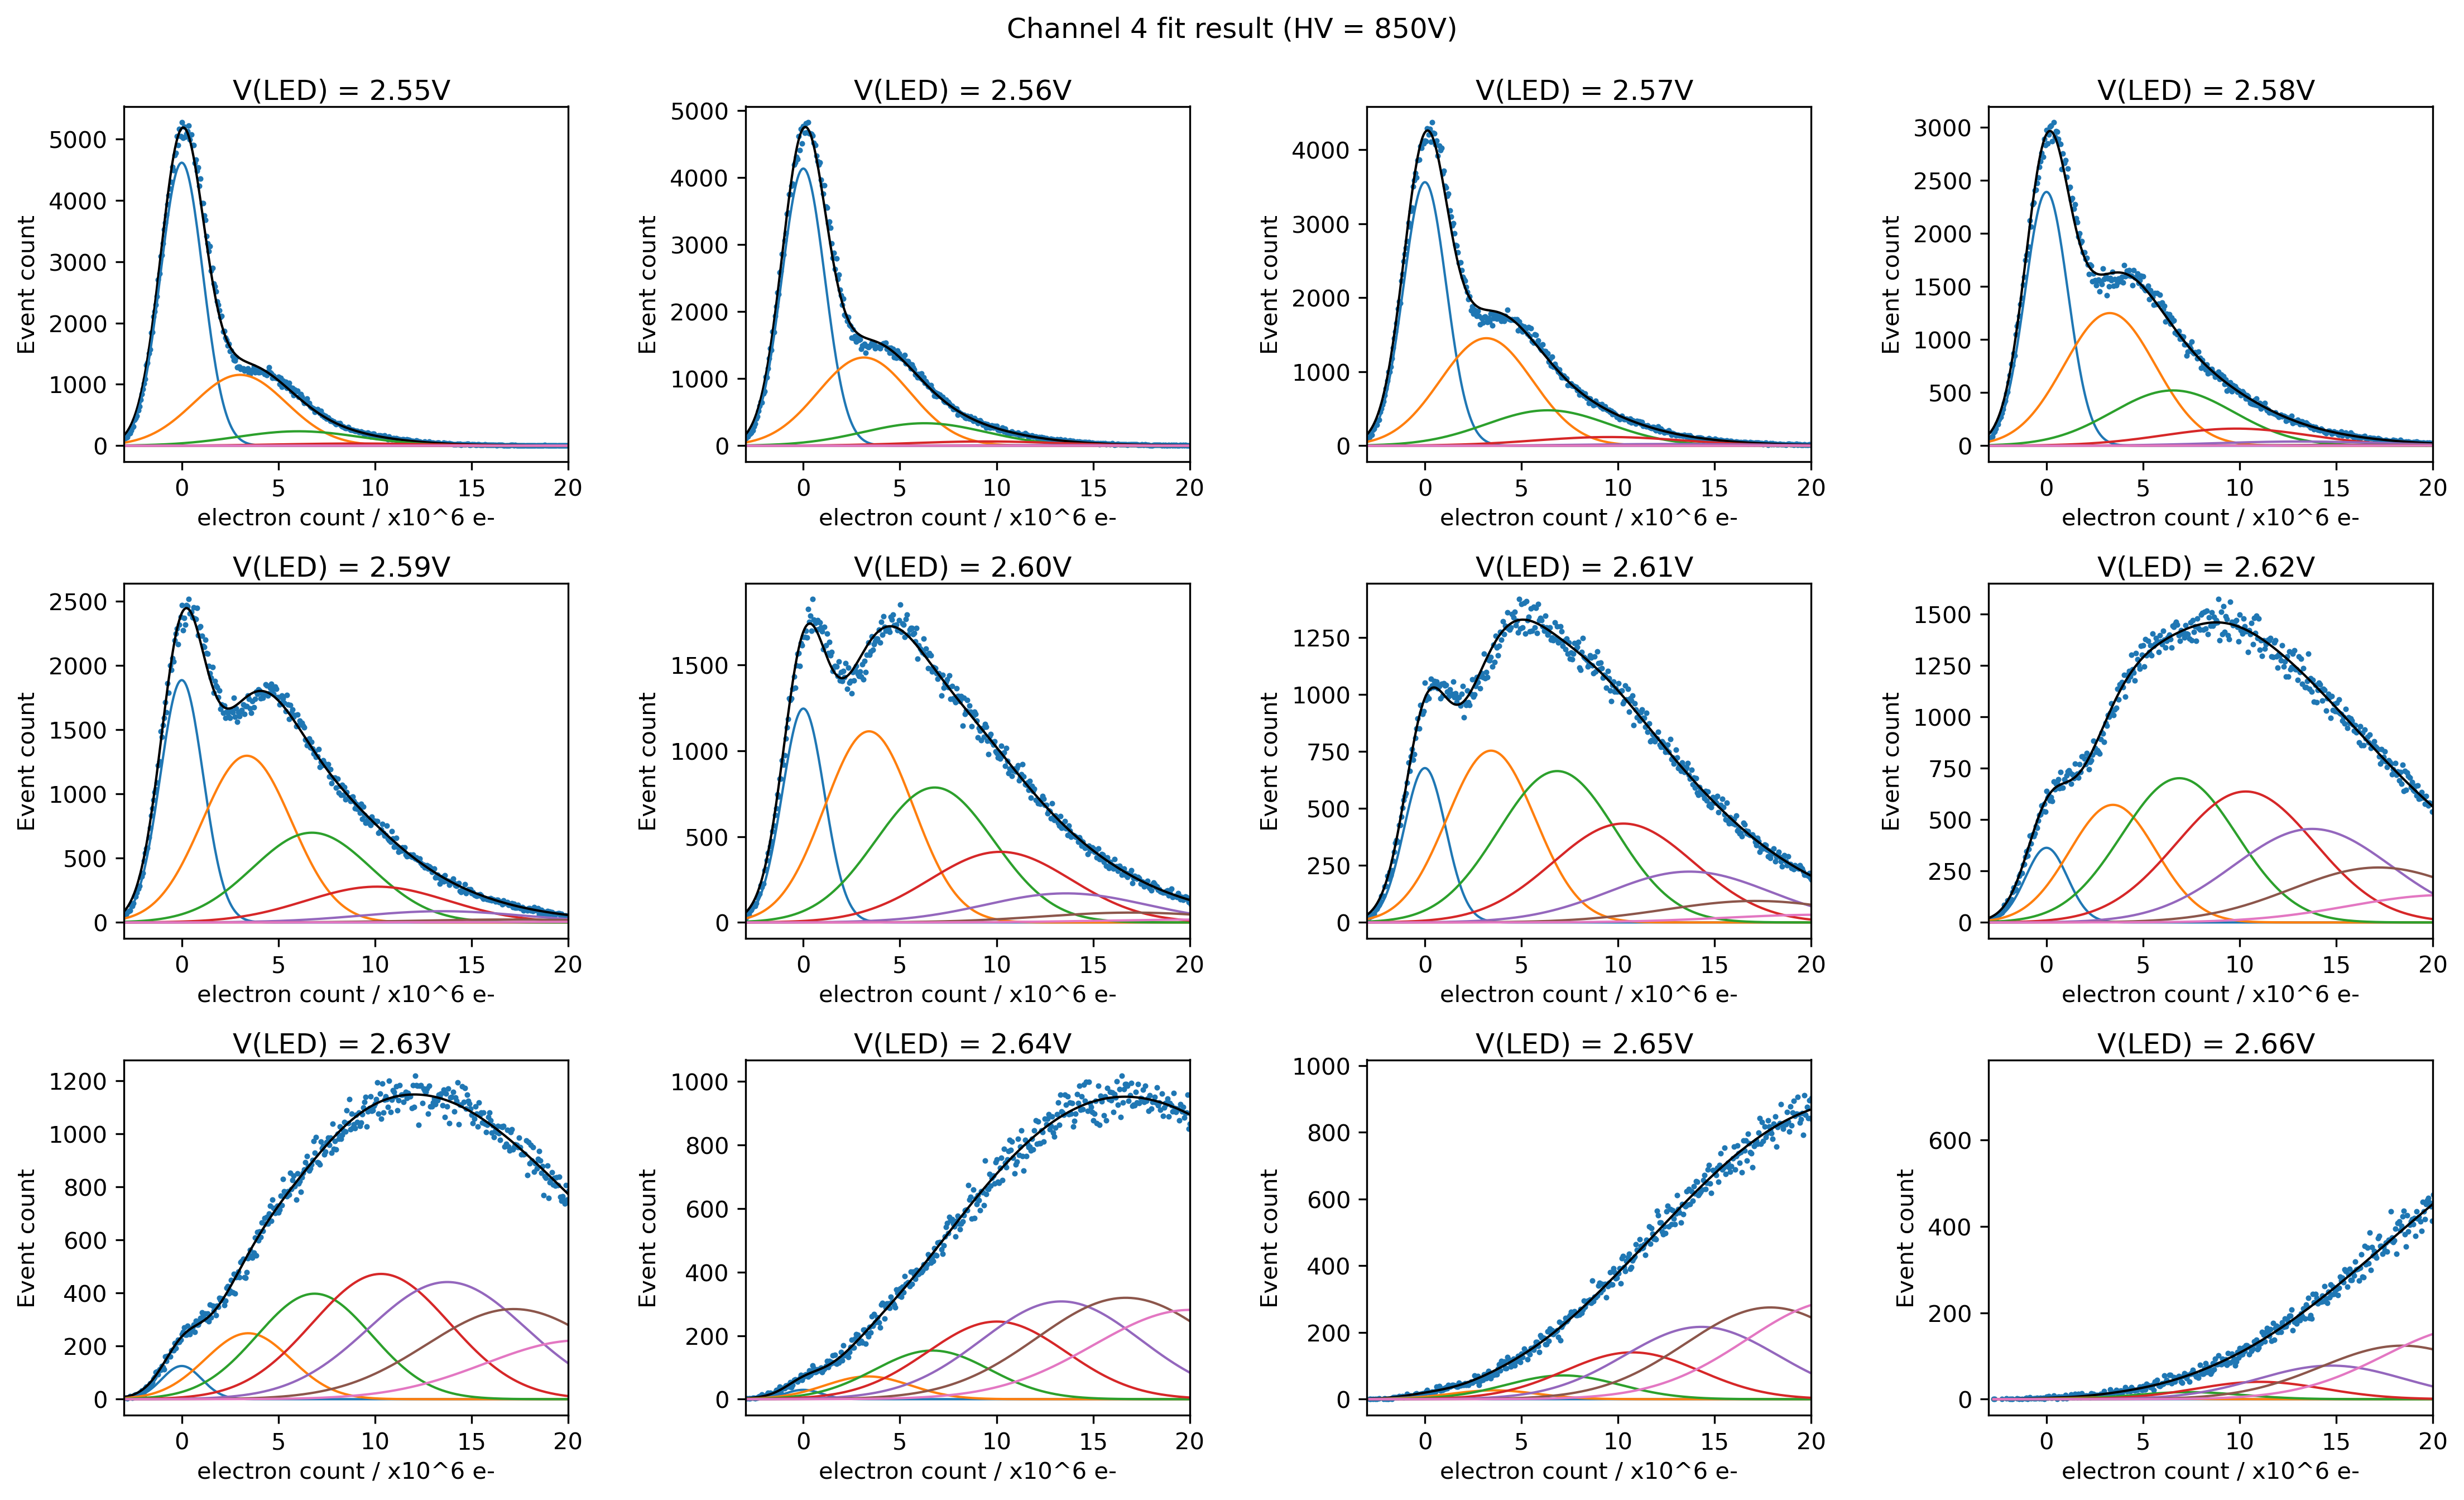

In [14]:
xlim_set = dict(zip(ch_list,[15, 10, 10 , 20]))
for chn, fit in fit_data.items():
    fig, ax = plt.subplots(3,4, dpi=300 , figsize = (15, 9))
    fig.suptitle(f'Channel {chn} fit result (HV = 850V)',y = .99)
    print('U        A          de        s0        se       lambda  σ-A    σ-de    σ-s0    σ-se   σ-lambda  ')
    for f in fit:
        volt, popt, pcov_d = f[0], f[1:6], f[6:]
        v = round(volt * 100 % 200)
        data = all_data[v][chn]
        dist = data.dist
        x = np.array(sorted(dist.keys()))
        y = np.array([dist[i] for i in x])
        x = x * data._default_scale
        print(f'{volt:.02f}', popt, pcov_d)

        # Plot
        v_id = v - id_min
        ax0 = ax[v_id // 4][v_id % 4]
        # ax0.set_yscale('log')   # log scale
        # ax0.set_ylim(10,1.2e4)  # log scale *
        ax0.plot(x,dist_func(x, *popt), c='0', linewidth = 1)
        for k in range(7):
            ax0.plot(x,dist_func_r(x, *popt, k) , linewidth = 1)
        plot(data, ax0, f'V(LED) = {volt:.02f}V ', scale=data._default_scale , xlim=(-3, xlim_set[chn]) , s=2)
    plt.tight_layout()
    # plt.savefig(f'ch{chn}-fit-log.png', dpi = 300)
    plt.savefig(f'ch{chn}-fit.png', dpi = 300)
    plt.show()

**Other Analysis**

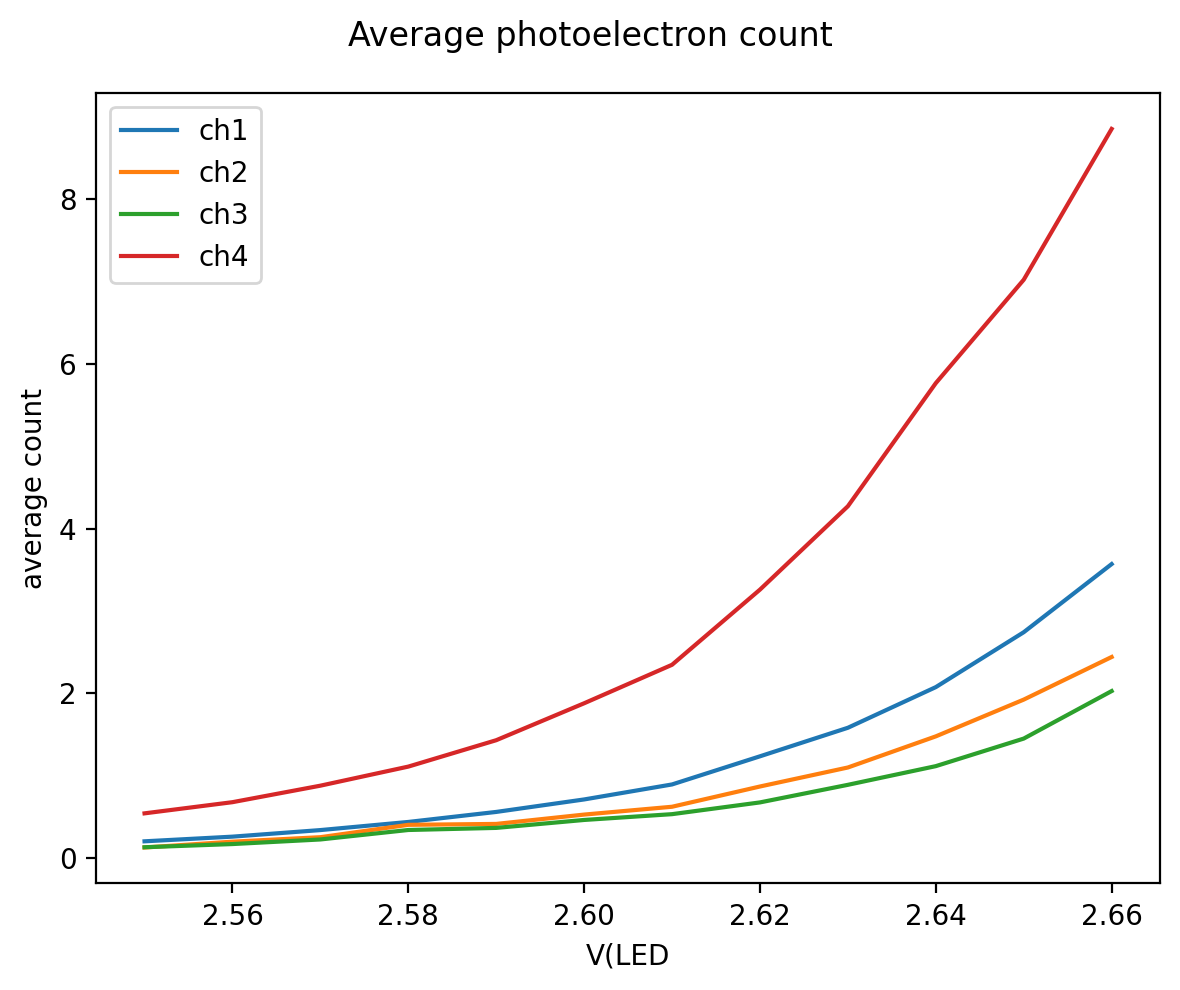

In [19]:
fig, ax = plt.subplots(dpi=200, figsize = (6,5))
fig.suptitle('Average photoelectron count')
legend = []
for chn, fit in fit_data.items():
    fit_T = fit.T
    volts = fit_T[0]
    popt_T = fit_T[5]
    ax.plot(volts, popt_T)
    # ax.scatter(volts, popt_T[5])
    legend.append(f'ch{chn}')
ax.set_xlabel('V(LED')
ax.set_ylabel('average count')
plt.legend(legend)
plt.tight_layout()
plt.savefig(f'avg-e-count.png', dpi = 300)
plt.show()
    

### Base STD Analysis

In [ ]:
for chn in range(1,5):
    fig, ax = plt.subplots(12,2, dpi=300 , figsize = (10, 25))
    fig.suptitle(f'Channel {chn} STD analysis',y = .99)
    for v in id_range:
        data = all_data[v][chn]
        base_std1 , base_std2 = {} , {}
        base = np.array(data.base_info).T
        for i in base[1]:
            try:
                base_std1[(i*100)//1] += 1
            except:
                base_std1[(i*100)//1] = 1
        for i in base[3]:
            try:
                base_std2[(i*100)//1] += 1
            except:
                base_std2[(i*100)//1] = 1
        base1avg , base2avg = np.sum(base[1])/len(base[1]) , np.sum(base[3])/len(base[3])
        base1x, base1y = np.array(list(base_std1.keys()))/100, list(base_std1.values())
        base2x, base2y = np.array(list(base_std2.keys()))/100, list(base_std2.values())
        v_id = v - id_min
        ax[v_id ][0].scatter(base1x, base1y, s=1)
        ax[v_id ][0].set_title(f'2.{v}V base1 std={base1avg:.4}')
        ax[v_id ][0].set_xlim(base1avg -1.3, base1avg + 2)
        ax[v_id ][1].scatter(base2x, base2y, s=1)
        ax[v_id ][1].set_title(f'2.{v}V base2 std={base2avg:.4}')
        ax[v_id ][1].set_xlim(base1avg -1.3, base1avg + 2)
    plt.tight_layout()
    plt.savefig(f'ch{chn}std.png',dpi=300)
    plt.show()
    # plt.close()

### Base Avg Analysis

In [ ]:
for chn in ch_list:
    fig, ax = plt.subplots(3,4, dpi=300 , figsize = (15, 9))
    fig.suptitle(f'Channel {chn} Average analysis',y = .99)
    for v in id_range:
        data = all_data[v][chn]
        base = np.array(data.base_info).T
        base_adif_arr = base[2] - base[0]
        base_adif_dist = {}
        for i in base_adif_arr:
            try:
                base_adif_dist[(i*100)//1] += 1
            except:
                base_adif_dist[(i*100)//1] = 1
        avg2 = np.sum(base[2])/len(base[2])
        avg1 = np.sum(base[0])/len(base[0])
        adif_avg = avg2-avg1
        # radif_avg = adif_avg / avg1
        x, y = np.array(list(base_adif_dist.keys()))/100, list(base_adif_dist.values())
        v_id = v - id_min
        ax[v_id // 4][v_id % 4].scatter(x,y,s=1)
        ax[v_id // 4][v_id % 4].set_title(f'2.{v}V    dif = {adif_avg:.3f}')
        ax[v_id // 4][v_id % 4].set_xlim(-5,5)
    plt.tight_layout()
    plt.savefig(f'ch{chn}bavg.png',dpi=300)
    plt.show()
    # plt.close()

### TEST & Trash



##### Print

In [20]:
with open("../../data/2_63V_raw_b0_seg0.bin", mode='rb') as file :
    for i in range(8):
        txt = file.read(4)
        btxt = [f"{bin(t)[2:]:0>8}" for t in txt]
        print(btxt)

['11010010', '00000000', '00000000', '10100000']
['00011000', '00000000', '00000000', '00000000']
['00000000', '00000000', '00000000', '00000000']
['10010100', '10001111', '00000001', '00000000']
['01100111', '00000000', '00000000', '00000000']
['00000100', '00011110', '00000011', '00000000']
['00000000', '00000000', '01111010', '00111011']
['01111000', '00111011', '01110111', '00111011']


##### Old Version

In [ ]:
# Decode file
for i in tqdm.tqdm([84, 67, 65, 63, 61]):
    data = analyse_raw_data(f'../../data/2_{i}V_raw_b0_seg0.bin')
    save_file(data, f"2_{i}")

# Plot other data
for i in [67, 65, 63, 61]:
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.8)
    data = read_file(f'raw_2_{i}.txt', mode='raw')
    for d in data:
        plot(d,f'2.{i}V ', scale=d._max_voltage * 4 *10 / (d._y_resolution * 50 * 1.6))
    plt.savefig(f'2.{i}V_find_peak_85_100_.png',dpi=300)
    plt.show()

In [ ]:
# Fit Method

def err_f(p, x , y, func):
    return func(x, *p) - y
    
## Method 2: Use `leasteq`
def process_data2(x,y):
    func , init_args= dist_func , [19000, 1.9, 0.1, 0.1, 10]
    err = lambda p, x, y: err_f(p, x, y, func)
    param = leastsq(err, x0=init_args, args=(x,y), maxfev=100000)
    popt ,flag= param
    return x, func(x, *popt), popt, flag

def process_data3(x,y):
    func = dist_func
    aim_func = lambda p : np.sum((func(x, *p)- y ) ** 2)
    p0 = (18000, 1.5, 0.9, 0.5, 1)
    bounds = ((15000,25000), (0.5,5), (0.5, 2), (0.1, 2), (0.1,15))
    result = basinhopping(aim_func, x0 = p0, minimizer_kwargs={'bounds' : bounds})
    popt = result.x
    return x , func(x , *popt), popt


# Fit Main

## Main
# for i in [67, 65, 63, 61]:
for i in [66]:
    plt.figure(dpi=150)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.8)
    data = read_file(f'dist_2_61111111.txt', mode='dist')
    print('Channel  A        de        s0        se       lambda      σ-A    σ-de    σ-s0    σ-se   σ-le  ')
    for chn in data:
        ## Get x, y range
        dist = chn.dist
        x = np.array(sorted(dist.keys()))
        y = np.array([dist[i] for i in x])
        x = x * (chn._max_voltage * 4 *10 / (chn._y_resolution * 50 * 1.6))

        # Fit curve (1) and analyse
        x_pre, y_pre, popt, pcov = process_data(x,y)
        print(chn.chn, popt, np.sqrt(np.diag(pcov)))
        # Fit curve (2) and analyse
        # x_pre, y_pre, popt, flag = process_data2(x,y)
        # print(chn.chn, popt, flag)
        # Fit curve (3) and analyse
        # x_pre, y_pre, popt = process_data3(x,y)
        # print(chn.chn, popt)
        
        ## plot result
        plt.subplot(220+chn.chn) # TEMP
        plt.scatter(x, y, s=1) 
        plt.xlim((-3,15))
        # plt.yscale('log')
        # plt.ylim(1,1e4)
        plt.plot(x,y_pre, c='0', linewidth = 1)  
        plt.plot(x,[dist_func(i, *popt) for i in x], linewidth = 1, c='0')
        for k in range(7):
            plt.plot(x,[dist_func_r(i, *popt, k) for i in x], linewidth = 1)
        plt.title(f"2.{i} @ CHN#{chn.chn}")
    plt.show()


**RESULT** (800V)

Not so good. Maybe there are something wrong with the model $F$. 

Take $n=30$:

Bad fit (fixed baseline):
- 2.67V channel 2
- 2.63V channel 1,2
- 2.61V channel 2,3

Bad fit (non-fixed baseline)
- 2.67V channel 2,4
- 2.65V channel 2
- 2.63V channel 2
- 2.61V channel 2

##### Other

##### TEST

In [ ]:
# i = 60
# data = analyse_raw_data(f'../../data/850/2_{i}_850V_raw_b0_seg0.bin')
# save_file(data, f"test")
# fig, ax = plt.subplots(2,2)
# xlim_set = [15, 10, 10 , 20]
# for d in data:
#     if d.event_count == 0:
#         continue
#     d.get_distribution()
#     d.dist.pop(0)
#     plot(d,ax[(d.chn-1) % 2][(d.chn-1) // 2] , f'2.{i}V ', scale=d._default_scale)
# plt.show()